<a href="https://colab.research.google.com/github/Rique3012/TransCal2/blob/main/Cilindro_Transferencia_Calor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<div class="markdown-google-sans">
  <h1>Damos-lhe as boas-vindas ao Colab!</h1>
</div>

<div class="markdown-google-sans">
  <h2>&#40;Novo&#41; Experimente a API Gemini</h2>
  <ul>
  <li><a href="https://makersuite.google.com/app/apikey">Generate a Gemini API key</a></li>
  <li><a href="https://colab.research.google.com/github/googlecolab/colabtools/blob/main/notebooks/Talk_to_Gemini_with_Google%27s_Speech_to_Text_API.ipynb?utm_medium=link&utm_campaign=gemini">Talk to Gemini with the Speech-to-Text API</a></li>
  <li><a href="https://colab.research.google.com/github/google/generative-ai-docs/blob/main/site/en/tutorials/quickstart_colab.ipynb?utm_medium=link&utm_campaign=gemini">Gemini API: Quickstart with Python</a></li>
  <li><a href="https://colab.research.google.com/notebooks/snippets/gemini.ipynb?utm_medium=link&utm_campaign=gemini">Gemini API code sample</a></li>
  <li><a href="https://colab.research.google.com/github/googlecolab/colabtools/blob/main/notebooks/Learning_with_Gemini_and_ChatGPT.ipynb?utm_medium=link&utm_campaign=gemini">Compare Gemini with ChatGPT</a></li>  
  <li><a href="https://colab.google/notebooks/?utm_medium=link&utm_campaign=gemini">More notebooks</a></li>
  </ul>
</div>


Se já conhece o Colab, veja este vídeo para saber mais sobre as tabelas interativas, a vista de histórico do código executado e a paleta de comandos.

<center>
  <a href="https://www.youtube.com/watch?v=rNgswRZ2C1Y" target="_blank">
  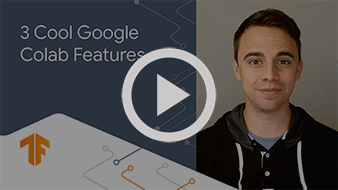
  </a>
</center>

<div class="markdown-google-sans">
  <h2>O que é o Colab?</h2>
</div>

O Colab, ou "Colaboratory", permite-lhe escrever e executar código Python no seu navegador com
- Sem configuração necessária
- Acesso às GPUs sem custo financeiro
- Partilha fácil

Quer seja <strong>aluno</strong>, <strong>cientista de dados</strong> ou <strong>investigador de IA</strong>, o Colab pode facilitar o seu trabalho. Veja a <a href="https://www.youtube.com/watch?v=inN8seMm7UI">Introdução ao Colab</a> para saber mais ou simplesmente comece a utilizá-lo abaixo!

<div class="markdown-google-sans">

## <strong>Introdução</strong>
</div>

O documento que está a ler não é uma página Web estática, mas sim um ambiente interativo chamado <strong>bloco de notas do Colab</strong> que lhe permite escrever e executar código.

Por exemplo, eis uma <strong>célula de código</strong> com um curto script do Python que calcula um valor, armazena-o numa variável e imprime o resultado:

In [ ]:
seconds_in_a_day = 24 * 60 * 60
seconds_in_a_day

86400

Para executar o código na célula acima, selecione-a com um clique e, em seguida, prima o botão Play à esquerda do código ou utilize o atalho de teclado "Command/Ctrl+Enter". Para editar o código, basta clicar na célula e começar a editar.

As variáveis que define numa célula podem ser utilizadas noutras células posteriormente:

In [ ]:
seconds_in_a_week = 7 * seconds_in_a_day
seconds_in_a_week

604800

Os blocos de notas do Colab permitem-lhe combinar <strong>código executável</strong> e <strong>texto rico</strong> num único documento, juntamente com <strong>imagens</strong>, <strong>HTML</strong>, <strong>LaTeX</strong> e muito mais. Quando cria os seus próprios blocos de notas do Colab, estes são armazenados na sua conta do Google Drive. Pode partilhar facilmente os seus blocos de notas do Colab com colegas de trabalho ou amigos, permitindo que estes comentem os seus blocos de notas ou até mesmo que os editem. Para saber mais, consulte <a href="/notebooks/basic_features_overview.ipynb">Vista geral do Colab</a>. Para criar um novo bloco de notas do Colab, pode utilizar o menu Ficheiro acima ou o seguinte link: <a href="http://colab.research.google.com#create=true">crie um novo bloco de notas do Colab</a>.

Os blocos de notas do Colab são blocos de notas do Jupyter alojados pelo Colab. Para saber mais acerca do projeto Jupyter, consulte <a href="https://www.jupyter.org">jupyter.org</a>.

<div class="markdown-google-sans">

## Ciência de dados
</div>

Com o Colab, pode aproveitar todo o poder das populares bibliotecas do Python para analisar e visualizar dados. A célula de código abaixo utiliza <strong>numpy</strong> para gerar alguns dados aleatórios e <strong>matplotlib</strong> para os visualizar. Para editar o código, basta clicar na célula e começar a editar.

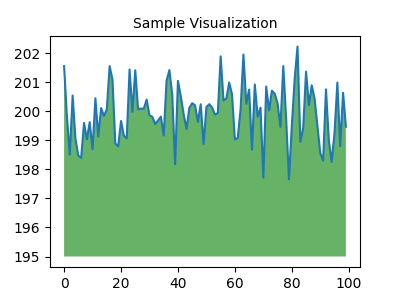

In [ ]:
import numpy as np
import IPython.display as display
from matplotlib import pyplot as plt
import io
import base64

ys = 200 + np.random.randn(100)
x = [x for x in range(len(ys))]

fig = plt.figure(figsize=(4, 3), facecolor='w')
plt.plot(x, ys, '-')
plt.fill_between(x, ys, 195, where=(ys > 195), facecolor='g', alpha=0.6)
plt.title("Sample Visualization", fontsize=10)

data = io.BytesIO()
plt.savefig(data)
image = F"data:image/png;base64,{base64.b64encode(data.getvalue()).decode()}"
alt = "Sample Visualization"
display.display(display.Markdown(F"""![{alt}]({image})"""))
plt.close(fig)

Pode importar os seus próprios dados para os blocos de notas do Colab a partir da sua conta do Google Drive, incluindo de folhas de cálculo, assim como do GitHub e de muitas outras fontes. Para saber mais acerca da importação de dados e de como o Colab pode ser utilizado para ciência de dados, consulte os links abaixo em <a href="#working-with-data">Trabalhar com dados</a>.

<div class="markdown-google-sans">

## Aprendizagem automática
</div>

Com o Colab, pode importar um conjunto de dados de imagem, preparar um classificador de imagens e avaliar o modelo, tudo isto com apenas <a href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/quickstart/beginner.ipynb">algumas linhas de código</a>. Os blocos de notas do Colab executam código nos servidores na nuvem da Google, o que significa que pode tirar partido da potência do hardware da Google, incluindo <a href="#using-accelerated-hardware">GPUs e TPUs</a>, independentemente da potência da sua máquina. Só precisa de um navegador.

O Colab é utilizado extensivamente na comunidade de aprendizagem automática com aplicações que incluem:
- Começar a utilizar o TensorFlow
- Desenvolver e preparar redes neurais
- Experiências com TPUs.
- Divulgar a investigação em IA
- Criar tutoriais

Para ver exemplos de blocos de notas do Colab que demonstram aplicações de aprendizagem automática, consulte os <a href="#machine-learning-examples">exemplos de aprendizagem automática</a> abaixo.

<div class="markdown-google-sans">

## Mais recursos

### Trabalhar com blocos de notas no Colab

</div>

- [Vista geral do Colaboratory](/notebooks/basic_features_overview.ipynb)
- [Guia sobre Markdown](/notebooks/markdown_guide.ipynb)
- [Importar bibliotecas e instalar dependências](/notebooks/snippets/importing_libraries.ipynb)
- [Guardar e carregar blocos de notas no GitHub](https://colab.research.google.com/github/googlecolab/colabtools/blob/main/notebooks/colab-github-demo.ipynb)
- [Formulários interativos](/notebooks/forms.ipynb)
- [Widgets interativos](/notebooks/widgets.ipynb)

<div class="markdown-google-sans">

<a name="working-with-data"></a>
### Trabalhar com dados
</div>

- [Carregar dados: Drive, Sheets e Google Cloud Storage](/notebooks/io.ipynb)
- [Gráficos: visualizar dados](/notebooks/charts.ipynb)
- [Comece a utilizar o BigQuery](/notebooks/bigquery.ipynb)

<div class="markdown-google-sans">

### Machine Learning Crash Course

<div>

Estes são alguns dos blocos de notas do curso online de aprendizagem automática da Google. Consulte o <a href="https://developers.google.com/machine-learning/crash-course/">Website do curso completo</a> para obter mais informações.
- [Introdução ao Pandas DataFrame](https://colab.research.google.com/github/google/eng-edu/blob/main/ml/cc/exercises/pandas_dataframe_ultraquick_tutorial.ipynb)
- [Regressão linear com tf.keras ao utilizar dados sintéticos](https://colab.research.google.com/github/google/eng-edu/blob/main/ml/cc/exercises/linear_regression_with_synthetic_data.ipynb)

<div class="markdown-google-sans">

<a name="using-accelerated-hardware"></a>
### Usar hardware acelerado
</div>

- [TensorFlow com GPUs](/notebooks/gpu.ipynb)
- [TensorFlow com TPUs](/notebooks/tpu.ipynb)

<div class="markdown-google-sans">

<a name="machine-learning-examples"></a>

### Exemplos em destaque

</div>

- <a href="https://colab.research.google.com/github/NVIDIA/NeMo/blob/stable/tutorials/VoiceSwapSample.ipynb">NeMo Voice Swap</a>: utilize o kit de ferramentas de IA de conversação NeMo da Nvidia para trocar uma voz num fragmento de áudio por uma gerada por computador.

- <a href="https://tensorflow.org/hub/tutorials/tf2_image_retraining">Preparar novamente um classificador de imagens</a>: crie um modelo do Keras baseado num classificador de imagens pré-preparado para distinguir flores.
- <a href="https://tensorflow.org/hub/tutorials/tf2_text_classification">Classificação de texto</a>: classifique as críticas cinematográficas do IMDB como <em>positivas</em> ou <em>negativas</em>.
- <a href="https://tensorflow.org/hub/tutorials/tf2_arbitrary_image_stylization">Transferência de estilo</a>: utilize a aprendizagem avançada para transferir o estilo entre imagens.
- <a href="https://tensorflow.org/hub/tutorials/retrieval_with_tf_hub_universal_encoder_qa">Perguntas e respostas sobre o codificador de frases universais multilíngue</a>: utilize um modelo de aprendizagem automática para responder a perguntas do conjunto de dados SQuAD.
- <a href="https://tensorflow.org/hub/tutorials/tweening_conv3d">Tipo de interpolação de vídeo</a>: preveja o que aconteceu num vídeo entre o primeiro e o último frame.


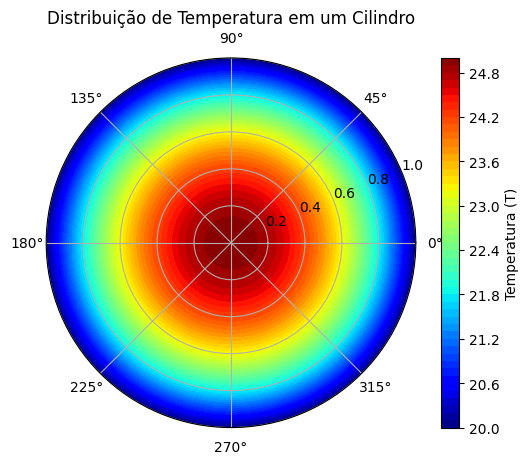

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Configurações da simulação
T0 = 20    # Temperatura inicial
S = 10     # Taxa de geração interna de calor
R = 1      # Raio do fio
K = 0.5    # Coeficiente de condução térmica
num_points = 200  # Número de pontos no diâmetro do fio

# Função para calcular a temperatura
def calculate_temperature(r, T0, S, R, K):
    return T0 + (S * R**2 / (4 * K)) * (1 - (r / R)**2)

# Gerar dados
theta = np.linspace(0, 2 * np.pi, num_points)
r = np.linspace(0, R, num_points)
T = calculate_temperature(r, T0, S, R, K)

# Criar um grid polar
r, theta = np.meshgrid(r, theta)

# Convertendo para coordenadas cartesianas
X = r * np.cos(theta)
Y = r * np.sin(theta)

# Mapeando as temperaturas para o grid
T_grid = calculate_temperature(r, T0, S, R, K)

# Configurar o plot
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
c = ax.contourf(theta, r, T_grid, 50, cmap=cm.jet)
fig.colorbar(c, ax=ax, label='Temperatura (T)')
ax.set_title('Distribuição de Temperatura em um Cilindro')
plt.show()
